In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import scipy.stats as stats
import numpy as np
import random
import copy
import pickle
import os
import sys
from IPython.display import clear_output

### Load data from path generation

In [3]:
try:
    from src.a_star import data  #note: MMWPF path must be added to enviornmental variables PYTHONPATH (see setup.py)
    data_path = data.path()
except:
    data_path = os.path.join("./", "data")
    if not os.path.exists(data_path):
        print('%s path does not exist, creating folder!' % data_path)

#load first set of 100 observations
fileName = 'exp_var3_100'
infile = open(data_path + fileName,'rb')
expl_dict = pickle.load(infile)
infile.close()
# load second set of 100 observations
fileName = 'exp_var5_100'
infile = open(data_path + fileName,'rb')
tmp1 = pickle.load(infile)
infile.close()

expl_dict.extend(tmp1)

fileName = 'beta3_100'
infile = open(data_path + fileName,'rb')
beta_dict = pickle.load(infile)
infile.close()
fileName = 'beta5_100'
infile = open(data_path + fileName,'rb')
tmp1 = pickle.load(infile)
infile.close()

beta_dict.extend(tmp1)

# print(expl_dict[22])

In [4]:
'''Build explMatrix'''
def BuildExplMatrix(expl_dict, beta_dict):
    explMatrix = np.zeros((observations, numPaths, numBetas))
    betaMatrix = np.zeros((observations, numPaths, numBetas))
    i=0
    for n in range(0, observations):
        for j in range(0, numPaths): 
            # re-map pickle dictionaries
            explMatrix[n][j][13] = expl_dict[i][0] #sK (x)
            explMatrix[n][j][12] = expl_dict[i][1] #nK (x)
            betaMatrix[n][j][12] = beta_dict[i][0] #sK (b)
            betaMatrix[n][j][11] = beta_dict[i][1] #nK (b)

            explMatrix[n][j][0] = expl_dict[i][2] #time_Car       (x)
            explMatrix[n][j][1] = expl_dict[i][6] #discomfort_Car (x)
            explMatrix[n][j][2] = expl_dict[i][10] #cost_Car      (x)
            betaMatrix[n][j][0] = beta_dict[i][2] #time_Car       (b)
            betaMatrix[n][j][1] = beta_dict[i][6] #discomfort_Car (b)
            betaMatrix[n][j][2] = beta_dict[i][10] #cost_Car      (b)

            explMatrix[n][j][3] = expl_dict[i][5] #time_Public       (x)
            explMatrix[n][j][4] = expl_dict[i][9] #discomfort_Public (x)
            explMatrix[n][j][5] = expl_dict[i][13] #cost_Public      (x)
            betaMatrix[n][j][3] = beta_dict[i][5] #time_Public       (b)
            betaMatrix[n][j][4] = beta_dict[i][9] #discomfort_Public (b)
            betaMatrix[n][j][5] = beta_dict[i][13] #cost_Public      (b)

            explMatrix[n][j][6] = expl_dict[i][3] #time_Bike         (x)
            explMatrix[n][j][7] = expl_dict[i][7] #discomfort_Bike   (x)
            explMatrix[n][j][8] = expl_dict[i][11] #cost_Bike        (x)
            betaMatrix[n][j][6] = beta_dict[i][3] #time_Bike         (b)
            betaMatrix[n][j][7] = beta_dict[i][7] #discomfort_Bike   (b)
            betaMatrix[n][j][8] = beta_dict[i][11] #cost_Bike        (b)

            explMatrix[n][j][9] = expl_dict[i][4] #time_Walk         (x)
            explMatrix[n][j][10] = expl_dict[i][8] #discomfort_Walk  (x)
            explMatrix[n][j][11] = expl_dict[i][12] #cost_Walk       (x)
            betaMatrix[n][j][9] = beta_dict[i][4] #time_Walk         (b)
            betaMatrix[n][j][10] = beta_dict[i][8] #discomfort_Walk  (b)
            betaMatrix[n][j][11] = beta_dict[i][12] #cost_Walk       (b)

            i = i+1
    return explMatrix, betaMatrix
            
numPaths = 4
numBetas = 14
observations = int(len(expl_dict)/numPaths) #get number of observations from pickle dictionary
explMatrix, betaMatrix = BuildExplMatrix(expl_dict, beta_dict)

print(observations)

200


### Generate True User Betas

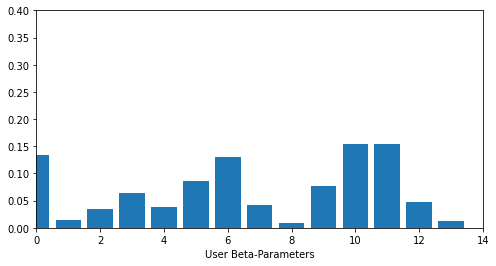

In [5]:
'''Generate True User Betas'''
plt.rcParams['figure.figsize'] = [8, 4] #normal figure size

np.random.seed(52) #<- fixed seed
betaList = np.random.randint(1, 100000, numBetas)
betaList = np.divide(betaList,np.sum(betaList))

np.random.seed(3) #<- fixed seed
betaList = np.power(betaList, np.random.randint(1, 8)) #enhances variation

userBetaList = np.divide(betaList,np.sum(betaList)) #normalize betas from 0 to 1

plt.figure(1)
plt.bar(list(range(0, numBetas)), userBetaList)
plt.xlim(0, numBetas)
plt.ylim(0, 0.4)
plt.xlabel('User Beta-Parameters');

### Estimate Scale Factor

In [7]:
def EstimateScaleFactor(X):
    numIter = 1000
    rnd_gen_base = 5
    rnd_seeds = [i*rnd_gen_base for i in range(0, numIter)]

    utilityVarList = []
    for i in range(0, numIter):
        #generate random "true user" betas at each iteration (simulates various users using this model)
        np.random.seed(rnd_seeds[i])
        betaList = np.random.randint(1, 100000, numBetas)
        betaList = np.divide(betaList,np.sum(betaList))
        betaList = np.power(betaList, np.random.randint(1,8)) #enhances variation

        randUserBetaList = np.divide(betaList,np.sum(betaList)) #normalize betas from 0 to 1

        for n in range(0, observations):
            utilityList = []
            for j in range(0, numPaths):
                utilityList.append(np.matmul(X[n][j], randUserBetaList))
            utilityVarList.append(np.var(utilityList)) #store the varience of the utilities in observation n

    utilityAvgVar = np.average(utilityVarList)
    scaleFactor = np.sqrt((np.square(np.pi)/6)/utilityAvgVar) 
    print('Average Utility Variance: %.6f ' % utilityAvgVar)
    print('Scale Factor: %.4f ' % scaleFactor)
    
    return scaleFactor

### Choice Filtering Functions

In [8]:
''' check probabilities '''
def GetProbability(B, X):
    C_n = list(np.matmul(X, np.transpose(B))) #matrix multiply path costs with the user betas to get choice set of utilities
    V_nk = max(C_n) #chosen alternative utility
    choice_k = C_n.index(max(C_n)) #chosen alternative index
    P_nk = np.divide(np.exp(V_nk), np.sum(np.exp(C_n))) #choice probabilty
#     print(P_nk)
    return P_nk

def CheckProbability(B, X, probThresh):
    C_n = list(np.matmul(X, np.transpose(B))) #matrix multiply path costs with the user betas to get choice set of utilities
    V_nk = max(C_n) #chosen alternative utility
    choice_k = C_n.index(max(C_n)) #chosen alternative index
    P_nk = np.divide(np.exp(V_nk), np.sum(np.exp(C_n))) #choice probabilty
    if P_nk <= probThresh:
        return False
    else:
        return True
    
def FilterChoicesProb(B, X, obsTarget):
    if obsTarget > observations:
        print('target number of observations is greater than len(explMatrix)')
        sys.exit()
    probList = []
    for n in range(0, observations):
        probList.append(GetProbability(B, X[n]))

    probThresh = 0.25
    stepSize = 0.025
    numObs = len(probList)
    while numObs != obsTarget:
        numObs = np.sum(np.array(probList) >= probThresh)
#         print(numObs)
        if numObs == obsTarget:
            break
        elif numObs > obsTarget:
            probThresh = probThresh + stepSize
        else:
            probThresh = probThresh - stepSize
            stepSize = stepSize/2.0
    print('numObs: %d\t probThresh: %.8f' %(numObs, probThresh))

    xTmp = []
    for n in range(0, observations):
        try:
            keep = CheckProbability(B, X[n], probThresh)
            if keep:
                xTmp.append(X[n])
        except:
            pass
        
    return xTmp

def FilterChoicesRand(X, obsTarget, seed=33):
    np.random.seed(seed)
    randomDrawList = np.sort(np.random.choice(range(0, observations), size=obsTarget, replace=False))

    print('numObs: %d' %(len(randomDrawList)))
    xTmp = []
    for n in range(0, obsTarget):
        xTmp.append(X[n])  
        
    return xTmp

### Newton-Raphson Functions

In [9]:
def ConvergenceCriteria(b_vec, b_vec_prev, ll_prime, ll_hessian, error2):
    e1, e2, e3 = False, False, False
    # convergence criteria from "Discrete Choice Analysis Theory and Application to Travel Demand" pg.82
    b_e1 = np.sqrt(np.sum(np.square(np.subtract(b_vec, b_vec_prev)))/len(b_vec))
    if b_e1 < 0.0001: #recomendation is 10e-4
        e1 = True
    
    b_e2 = []
    for b in range(0, len(b_vec)):
        # convergence criteria from "Discrete Choice Analysis Theory and Application to Travel Demand" pg.83
        b_e2.append(np.divide(abs(np.subtract(b_vec[b], b_vec_prev[b])), abs(b_vec_prev[b])))
        if b_e2[b] < error2: #recomendation is 10e-2
            e2 = True #all b_e2 must be < 0.1
        else:
            e2 = False
            break #only one b_e2 > 0.1 breaks for-loop 
            
    b_e3 = []
    for b in range(0, len(b_vec)):
        # convergence criteria from "Discrete Choice Methods with Simulation" pg.202
        b_e3.append(abs(np.sum([ll_prime[bb]*(-1.0 / ll_hessian[b]) for bb in range(0, numBetas)])*ll_prime[b]))
        if b_e3[b] < 10e-5:
            e3 = True #all b_e3 must be < 0.0001
        else:
            e3 = False
            break #only one b_e3 > 0.0001 breaks for-loop 
            
    clear_output(wait=True)    
    if e1 == True or e2 == True or e3 == True:
        print('e1: %r' % e1)
        print('e2: %r' % e2)
        print('e3: %r' % e3)
        converged = True
    else:
        converged = False
        
    if np.average(np.abs(ll_prime)) < 0.0001:
        print('F.O.C average LL ~= 0')
        if i > 4:
            converged = True
        
    return converged, b_e1, b_e2, b_e3

def GetChoiceSet(X, B):
    Y_nk = []
    C_n = []
    betaLearned = []
    for n in range(0, observations): #for n observations build Choice Set and collect choices

        #matrix multiply path explanitory variables with the user betas to get a choice set of utilities
        C_n.append(list(np.matmul(X[n], np.transpose(B)))) 

        #pick path with max utility for each observation n and save the index of that choice
        Y_nk.append(C_n[n].index(max(C_n[n])))  
        
    return Y_nk

def NewtonRaphson(X, Y_nk, e2=0.1):
    
    plt.rcParams['figure.figsize'] = [8, 6]
    logging = False   

    b_vec = np.zeros(numBetas)
    b_vec_prev = np.ones(numBetas)
    ll_prime = np.ones(numBetas)
    ll_hessian = np.ones(numBetas)
    ll_prev = -99999999 #set to really small for first iteration
    forceQuit = False

    for i in range(0, 500):

        stepSize = 1.0
        x_n_b = np.zeros((observations, numBetas))
        f_n_b = np.zeros((observations, numBetas))
        h_n_b = np.zeros((observations, numBetas))

        # before continuing with the next iteration, confirm that the new ll value has increased
        while stepSize > 0.0001220703125:
            v_n_j = np.zeros((observations, numPaths))
            g_n = []
            ll_n = []
            for n in range(0, observations): #for n observations

                #1st partial derivative denominator: e^B'*X_n,j
                v_n_j[n] = [np.matmul(X[n][j], b_vec) for j in range(0, numPaths)]
                g_n.append(np.sum([np.exp(v_n_j[n][j]) for j in range(0, numPaths)]))

                #log likelihood 
                ll_n.append(np.log(np.exp(np.matmul(X[n][Y_nk[n]], b_vec)) / g_n[n]))

            ll = np.sum(ll_n)

            #if log likelihood has overshot maximum, then reduce step size and recaculate b_vec
            if ll < ll_prev:
                stepSize = stepSize/2.0
                # get a new b_vec with reduced stepSize
                for b in range(0, numBetas):
                    b_vec[b] = b_vec_prev[b] - (stepSize*(ll_prime[b]/ll_hessian[b])) 
                    #print('Beta_%d: %.6f\t Prev: %.6f\t  LL: %.6f\t LL_prime: %.6f\t Hessian: %.6f' % (b, b_vec[b], b_vec_prev[b], ll, ll_prime[b], ll_hessian[b]))
                if stepSize < 0.0001220703125:   
                    print('stepSize too Small!!!')
                    forceQuit = True
            else:
                break

        converged, b_e1, b_e2, b_e3 = ConvergenceCriteria(b_vec, b_vec_prev, ll_prime, ll_hessian, e2) 
        
        if logging == False:
            
            print('Iteration: %d\t LL: %.4f\t LL_prime_avg: %.4f\t Hessian_avg: %.4f\t\n' \
                  'e1: %.8f\t #e2: %d\t e3_avg: %.8f' % (i, ll, np.average(ll_prime), np.average(ll_hessian), 
                                                     b_e1, (numBetas-len(b_e2)), np.average(b_e3)))
            betaLearnedList = []
            for b in range(0, numBetas):
                betaLearnedList.append(np.exp(b_vec[b]/1))

            betaLearnedList = np.divide(betaLearnedList,np.sum(betaLearnedList))   

            plt.figure(1)    
            plt.bar(list(range(0, numBetas)), betaLearnedList, alpha=1.0, color='b', label='learned betas')
            plt.bar(list(range(0, numBetas)), userBetaList, alpha=0.5, width=0.5, color='r', label='user betas')
            plt.xlim(0, numBetas)
            plt.ylim(0, 0.5)
            plt.xlabel('Beta-Parameters')
            plt.legend(loc="upper right")
            plt.show()
            
        if converged or forceQuit: #if one of the convergence criteria tests is satisfied
            for b in range(0, numBetas):
                print('Beta_%d: %.6f\t LL: %.6f\t LL_prime: %.6f\t Hessian: %.6f' % 
                                      (b, b_vec[b], ll, ll_prime[b], ll_hessian[b]))
            break

        ll_prev = ll #save previous log likelihood value to compare in the next iteration. ll must always increase during each iteration

        for n in range(0, observations): #for n observations    
            # iterate through the beta vector to find partial for each beta
            for b in range(0, numBetas):
                #1st partial derivative of dVn,k/dB0 in observation n
                x_n_b[n][b] = X[n][Y_nk[n]][b]

                #1st partial derivative numerator: x_n,j,b_idx * e^V_n,j  note: path choice i not relevant here
                f_n_b[n][b] = np.sum([X[n][j][b]*np.exp(v_n_j[n][j]) for j in range(0, numPaths)])

                #2nd partial derivative of beta b (f_prime*g - g_prime*f) / g^2
                f_prime_g = []
                g_prime_f = []
                for j in range(0, numPaths):
                    xfg = np.square(X[n][j][b]) #f_prime leading constants
                    for jj in range(0, numPaths):
                        xgf = X[n][j][b]*X[n][jj][b]
                        x_vec = []
                        for bb in range(0, numBetas):
                            #generate (x + x) vector
                            x_vec.append(X[n][j][bb]+X[n][jj][bb])

                        v_x_vec = np.matmul(x_vec, b_vec)    
                        f_prime_g.append(xfg*np.exp(v_x_vec))
                        g_prime_f.append(xgf*np.exp(v_x_vec))

                h_n_b[n][b] = 0.0 - ((np.sum(f_prime_g) - np.sum(g_prime_f)) / np.square(g_n[n]))

        b_vec_prev = b_vec.copy() #need to deep copy array here
        ll_prime = np.zeros(numBetas)
        ll_hessian = np.zeros(numBetas)
        stepSize = 1.0 #reset stepSize = 1.0
        for b in range(0, numBetas):
            for n in range(0, observations):
                ll_prime[b] = ll_prime[b] + (x_n_b[n][b] - (f_n_b[n][b] / g_n[n]))
                ll_hessian[b] = ll_hessian[b] + h_n_b[n][b]

            b_vec[b] = b_vec_prev[b] - (stepSize*(ll_prime[b]/ll_hessian[b]))
            if logging:
                print('Beta_%d: %.6f\t LL: %.6f\t LL_prime: %.6f\t Hessian: %.6f' % 
                                      (b, b_vec[b], ll, ll_prime[b], ll_hessian[b]))

    return b_vec


### Post Newton-Raphson Functions

In [10]:
''' get and plot learned betas'''
def PlotBetaComparison(B, label, yAxis=0.8, saveFig=False, title='figure'):
    plt.rcParams['figure.figsize'] = [8, 6] #bigger figure size
    fig = plt.figure(1)    
    plt.bar(list(range(0, numBetas)), B, alpha=1.0, color='b', label=label)
    plt.bar(list(range(0, numBetas)), userBetaList, alpha=0.5, width=0.5, color='r', label='user betas')
    plt.xlim(0, numBetas)
    plt.ylim(0, yAxis)
    plt.title(title, fontsize=18)
    plt.xlabel('Beta-Parameters', fontsize=18)
    plt.ylabel('Averseness  e^(β)', fontsize=18)
    plt.legend(loc="upper right",fontsize=18)
    plt.show()
    if saveFig:
        fig_path = os.path.join("./", "fig/")
        if not os.path.exists(fig_path):
            print('%s path does not exist, creating folder!' % fig_path)
            os.makedirs(fig_path)
        fig.savefig(fig_path + title + '.png', dpi=100)
    
def GetLearnedBetas(b_vec, yAxis=0.5, saveFig=False, title='figure'):
    betaLearnedList = []
    for b in range(0, numBetas):
        betaLearnedList.append(np.exp(b_vec[b]))
    betaLearnedList = np.divide(betaLearnedList,np.sum(betaLearnedList))  

    betaError = []
    for b in range(0, numBetas):
        betaError.append(abs(userBetaList[b] - betaLearnedList[b]))

    print('mean abs error: %.4f' % round(np.average(betaError),8))
    
    PlotBetaComparison(betaLearnedList, 'learned betas', yAxis=yAxis, saveFig=saveFig, title=title)
    
    return betaLearnedList

''' compare choice outcomes '''
def CompareChoiceOutcomes(X, BL):
    C_orig_n = []
    C_learned_n = []
    choice_orig_nk = []
    choice_learned_nk = []
    choice_orig2_nk = []
    choice_learned2_nk = []
    for n in range(0, observations): #for n observations build Choice Set and collect choices

            #matrix multiply path explanitory variables with the user betas to get a choice set of utilities
            C_orig_n.append(list(np.matmul(X[n], np.transpose(userBetaList)))) 
            #pick path with max utility for each observation n and save the index of that choice
            choice_orig_nk.append(C_orig_n[n].index(max(C_orig_n[n])))   

            #convert max from list to really negative to then check for 2nd best
            C_orig_n[n][choice_orig_nk[n]] = -9999999
            choice_orig2_nk.append(C_orig_n[n].index(max(C_orig_n[n]))) 

            #matrix multiply path explanitory variables with the learned betas to get a choice set of utilities
            C_learned_n.append(list(np.matmul(X[n], np.transpose(BL)))) 
            #pick path with max utility for each observation n and save the index of that choice
            choice_learned_nk.append(C_learned_n[n].index(max(C_learned_n[n])))  

            #convert max from list to really negative to then check for 2nd best
            C_learned_n[n][choice_learned_nk[n]] = -9999999
            choice_learned2_nk.append(C_learned_n[n].index(max(C_learned_n[n]))) 

    match1 = 0
    for i in range(0, len(choice_orig_nk)):
        if choice_orig_nk[i] == choice_learned_nk[i]:
            match1 = match1 + 1

    match2 = 0
    for i in range(0, len(choice_orig2_nk)):
        if choice_orig2_nk[i] == choice_learned2_nk[i]:
            match2 = match2 + 1

    match3 = 0
    for i in range(0, len(choice_orig_nk)):
        if choice_orig_nk[i] == choice_learned2_nk[i]:
            match3 = match3 + 1

    print(choice_orig_nk)  
    print(choice_learned_nk)
    print('1st best matches to true user betas: %d out of %d\n%%-of-right: %.1f\n' % (match1, len(choice_orig_nk), (100*(match1/len(choice_orig_nk)))))

#     print(choice_orig2_nk)  
#     print(choice_learned2_nk)
#     print('2nd best matches to true user betas: %d out of %d\n' % (match2, len(choice_orig2_nk)))

    print(choice_orig_nk)  
    print(choice_learned2_nk)
    print('2nd best matches compared to 1st best: %d out of %d\n' % (match3, len(choice_orig2_nk)))
    
    print('%%-of-right incl first + second: %.1f' % (100*((match1 + match3)/len(choice_orig_nk))))

''' calculate likelihood ratio index '''
def LiklihoodRatioIndex(X, b_vec, Y_nk):
    
    v_n_j = np.zeros((observations, numPaths))
    g_n = []
    ll_n = []
    b_vec0 = np.zeros(numBetas)
    for n in range(0, observations): #for n observations

        #1st partial derivative denominator: e^B'*X_n,j
        v_n_j[n] = [np.matmul(X[n][j], b_vec0) for j in range(0, numPaths)]
        g_n.append(np.sum([np.exp(v_n_j[n][j]) for j in range(0, numPaths)]))

        #log likelihood 
        ll_n.append(np.log(np.exp(np.matmul(X[n][Y_nk[n]], b_vec0)) / g_n[n]))

    ll_0 = np.sum(ll_n)

    v_n_j = np.zeros((observations, numPaths))
    g_n = []
    ll_n = []
    b_vecResult = b_vec #b_vec is output of 
    for n in range(0, observations): #for n observations

        #1st partial derivative denominator: e^B'*X_n,j
        v_n_j[n] = [np.matmul(X[n][j], b_vecResult) for j in range(0, numPaths)]
        g_n.append(np.sum([np.exp(v_n_j[n][j]) for j in range(0, numPaths)]))

        #log likelihood 
        ll_n.append(np.log(np.exp(np.matmul(X[n][Y_nk[n]], b_vecResult)) / g_n[n]))

    ll_result = np.sum(ll_n)
    print('\nLL(B) = %.6f' %ll_result)
    print('LL(0) = %.6f' %ll_0)
    print('LRI: %.4f' %(1 - (ll_result/ll_0)))

In [11]:
''' backup explMatrix '''
explMatrix_bkup = copy.deepcopy(explMatrix)

#### Filter 1 (filter by probability threshold)

In [12]:
''' recover explMatrix '''
explMatrix = copy.deepcopy(explMatrix_bkup)
observations = len(explMatrix)

''' filter choice probabilites to be above some value '''
explMatrix = FilterChoicesProb(userBetaList, explMatrix, 100)
observations = len(explMatrix)

filterName = 'Probability Filter β_user'

numObs: 100	 probThresh: 0.26206055


#### Filter 2 (filter by random draw)

In [ ]:
''' recover explMatrix '''
explMatrix = copy.deepcopy(explMatrix_bkup)
observations = len(explMatrix)

''' filter choice probabilites to be above some value '''
explMatrix = FilterChoicesRand(explMatrix, 100, seed=33)
observations = len(explMatrix)

filterName = 'Random Filter β_user'

#### Filter 3 (no filter)

In [ ]:
''' recover explMatrix '''
explMatrix = copy.deepcopy(explMatrix_bkup)
observations = len(explMatrix)

filterName = 'No Filter β_user'

#### Calculate and apply scale factor before running NR

In [13]:
''' estimate scale factor '''
scaleFactor = EstimateScaleFactor(explMatrix)

''' apply scale factor '''
explMatrixScaled = np.multiply(scaleFactor, explMatrix)

Average Utility Variance: 0.011095 
Scale Factor: 12.1763 


e1: False
e2: True
e3: False
Iteration: 91	 LL: -26.7883	 LL_prime_avg: 0.5961	 Hessian_avg: -87.3820	
e1: 0.00972392	 #e2: 0	 e3_avg: 0.07606869


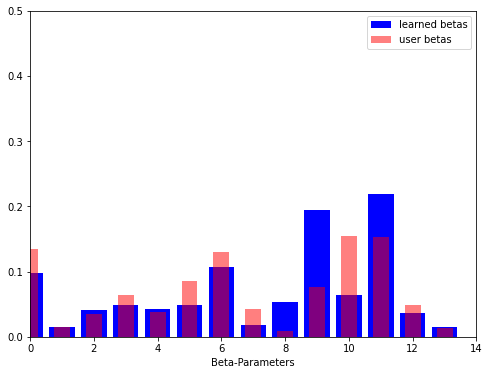

Beta_0: 1.971588	 LL: -26.788291	 LL_prime: -0.155807	 Hessian: -17.092771
Beta_1: 0.062685	 LL: -26.788291	 LL_prime: -1.631824	 Hessian: -65.591440
Beta_2: 1.084373	 LL: -26.788291	 LL_prime: -0.283285	 Hessian: -56.505027
Beta_3: 1.263078	 LL: -26.788291	 LL_prime: 0.279952	 Hessian: -5.560133
Beta_4: 1.142599	 LL: -26.788291	 LL_prime: 0.257621	 Hessian: -5.545101
Beta_5: 1.263078	 LL: -26.788291	 LL_prime: 0.279952	 Hessian: -5.560133
Beta_6: 2.058436	 LL: -26.788291	 LL_prime: 1.719338	 Hessian: -18.899773
Beta_7: 0.294527	 LL: -26.788291	 LL_prime: 8.046587	 Hessian: -279.550467
Beta_8: 1.357139	 LL: -26.788291	 LL_prime: 2.607800	 Hessian: -43.479299
Beta_9: 2.649712	 LL: -26.788291	 LL_prime: 0.006841	 Hessian: -0.907853
Beta_10: 1.544315	 LL: -26.788291	 LL_prime: -0.000776	 Hessian: -1.383330
Beta_11: 2.768949	 LL: -26.788291	 LL_prime: 0.006546	 Hessian: -0.831348
Beta_12: 0.982257	 LL: -26.788291	 LL_prime: 0.719515	 Hessian: -37.035600
Beta_13: 0.135515	 LL: -26.788291	 L

In [14]:
''' get choice set and run Newton-Raphson '''
choice_nk = GetChoiceSet(explMatrixScaled, userBetaList) 
b_vec = NewtonRaphson(explMatrixScaled, choice_nk, e2=0.1) #Inputs: X, Ynk(dummy variable), e2 convergence criteria

mean abs error: 0.0342


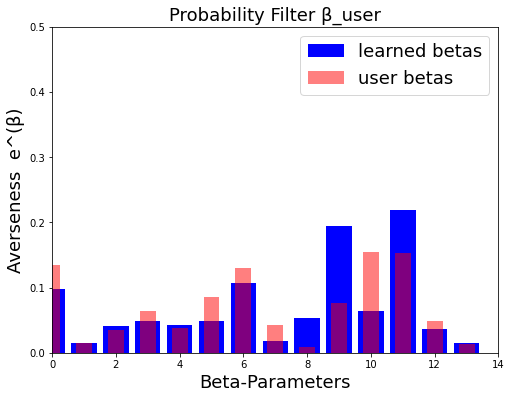

In [15]:
''' get learned betas '''
betaLearnedList = GetLearnedBetas(b_vec, yAxis=0.5, saveFig=False, title=filterName)

In [16]:
CompareChoiceOutcomes(explMatrixScaled, betaLearnedList)
LiklihoodRatioIndex(explMatrixScaled, b_vec, choice_nk)

[0, 2, 0, 0, 3, 2, 2, 0, 1, 1, 0, 0, 3, 3, 0, 0, 1, 2, 0, 2, 3, 0, 3, 0, 1, 3, 1, 1, 2, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 1, 3, 2, 2, 1, 0, 0, 3, 0, 2, 0, 3, 3, 0, 1, 0, 0, 2, 3, 2, 1, 1, 0, 0, 2, 3, 2, 0, 3, 1, 3, 3, 3, 1, 2, 0, 1, 3, 2, 1, 1, 3, 0, 2, 3, 3, 3, 1, 2, 0, 1, 3, 2, 1, 2, 2, 0, 2, 2, 2, 2]
[0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 2, 0, 2, 3, 0, 3, 0, 1, 3, 1, 0, 1, 3, 1, 1, 3, 2, 3, 1, 3, 3, 3, 1, 3, 2, 2, 2, 0, 0, 3, 0, 2, 0, 3, 3, 0, 1, 0, 0, 3, 3, 2, 0, 1, 0, 0, 2, 2, 2, 0, 2, 1, 3, 3, 3, 1, 2, 0, 1, 3, 2, 1, 1, 3, 0, 2, 3, 0, 3, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2]
1st best matches to true user betas: 87 out of 100
%-of-right: 87.0

[0, 2, 0, 0, 3, 2, 2, 0, 1, 1, 0, 0, 3, 3, 0, 0, 1, 2, 0, 2, 3, 0, 3, 0, 1, 3, 1, 1, 2, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 1, 3, 2, 2, 1, 0, 0, 3, 0, 2, 0, 3, 3, 0, 1, 0, 0, 2, 3, 2, 1, 1, 0, 0, 2, 3, 2, 0, 3, 1, 3, 3, 3, 1, 2, 0, 1, 3, 2, 1, 1, 3, 0, 2, 3, 3, 3, 1, 2, 0, 1, 3, 2, 1, 2, 2, 0, 2, 2, 2, 2]
[1, 1, 3, 2, 0, 0, 1, 3, 3, 

#### Save Learned Betas

In [18]:
# file path for preprocessed dataframes
try:
    from src.a_star import prep_dataframes  #note: MMWPF path must be added to enviornmental variables PYTHONPATH (see setup.py)
    prep_path = prep_dataframes.path()
except:
    prep_path = os.path.join("./", "prep_dataframes")
    if not os.path.exists(prep_path):
        print('%s path does not exist!' % prep_path)
        
# save precalculated lst_id to file
beta_file_name = os.path.join(prep_path, "b_user_probability_filter_betas")
try: 
    geeky_file = open(beta_file_name, 'wb') 
    pickle.dump(betaLearnedList, geeky_file) 
    geeky_file.close() 
except: 
    print("Something went wrong")

### Simulated Survey

[0.06145807 0.06145807 0.06145807 0.06278244 0.06278244 0.06278244
 0.06032759 0.06032759 0.06032759 0.12844515 0.12844515 0.12844515
 0.04808456 0.01287571]


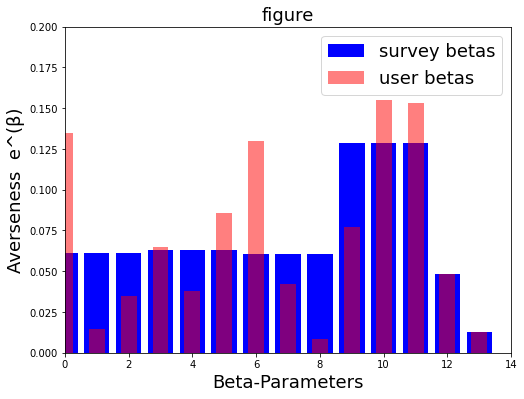

In [19]:
''' simulated survey '''
userBetaAvg = [np.average(userBetaList[b-2:b+1]) for b in range(0, numBetas-2) if((b % 3) == 2)] #get 3-way averages
userBetaAvg.append(userBetaList[-2]) #Nk (number of transfers)
userBetaAvg.append(userBetaList[-1]) #Sk (sustainability)

userBetaAvgNorm = np.divide(userBetaAvg,np.sum(userBetaAvg))
surveyBetaList = []
# re-create a 14 element vector: surveyBetaList
for i in range(0, len(userBetaAvgNorm)):
    if i < 4:
        for ii in range(0, 3): #copy userBetaAvgNorm[i] 3 times
            surveyBetaList.append(userBetaAvgNorm[i])
    else:
        surveyBetaList.append(userBetaAvgNorm[i])
        
surveyBetaList = np.divide(surveyBetaList,np.sum(surveyBetaList)) #normalize surveyBetaList from 0 to 1
print(surveyBetaList)
PlotBetaComparison(surveyBetaList, 'survey betas', yAxis=0.2)

#### Filter 1 (filter by probability threshold)

In [20]:
''' recover explMatrix '''
explMatrix = copy.deepcopy(explMatrix_bkup)
observations = len(explMatrix)

''' filter choice probabilites to be above some value '''
explMatrix = FilterChoicesProb(surveyBetaList, explMatrix, 100)
observations = len(explMatrix)

filterName = 'Probability Filter β_survey'

numObs: 100	 probThresh: 0.26054687


#### Filter 2 (filter by random draw)

In [ ]:
''' recover explMatrix '''
explMatrix = copy.deepcopy(explMatrix_bkup)
observations = len(explMatrix)

''' filter choice probabilites to be above some value '''
explMatrix = FilterChoicesRand(explMatrix, 100, seed=33)
observations = len(explMatrix)

filterName = 'Random Filter β_survey'

#### Filter 3 (no filter)

In [385]:
''' recover explMatrix '''
explMatrix = copy.deepcopy(explMatrix_bkup)
observations = len(explMatrix)

filterName = 'No Filter β_survey'

#### Calculate and apply scale factor before running NR

In [21]:
''' estimate scale factor '''
scaleFactor = EstimateScaleFactor(explMatrix)

''' apply scale factor '''
explMatrixScaled = np.multiply(scaleFactor, explMatrix)

Average Utility Variance: 0.011043 
Scale Factor: 12.2046 


e1: False
e2: True
e3: False
Iteration: 74	 LL: -30.4330	 LL_prime_avg: 0.9322	 Hessian_avg: -116.4339	
e1: 0.01362045	 #e2: 0	 e3_avg: 0.23659166


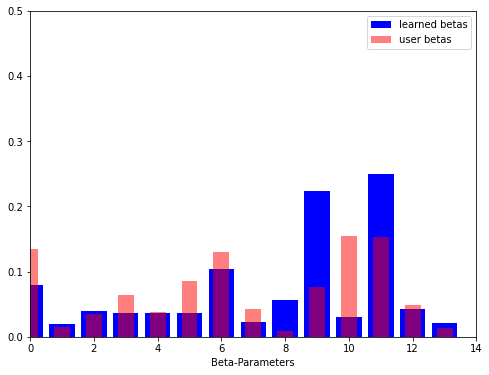

Beta_0: 1.508174	 LL: -30.432962	 LL_prime: -0.431630	 Hessian: -23.809348
Beta_1: 0.082211	 LL: -30.432962	 LL_prime: -2.291358	 Hessian: -91.739740
Beta_2: 0.829496	 LL: -30.432962	 LL_prime: -0.784782	 Hessian: -78.708589
Beta_3: 0.752128	 LL: -30.432962	 LL_prime: 1.104142	 Hessian: -24.021398
Beta_4: 0.730591	 LL: -30.432962	 LL_prime: 1.083625	 Hessian: -24.030109
Beta_5: 0.752128	 LL: -30.432962	 LL_prime: 1.104142	 Hessian: -24.021398
Beta_6: 1.782705	 LL: -30.432962	 LL_prime: 2.331809	 Hessian: -22.315342
Beta_7: 0.289792	 LL: -30.432962	 LL_prime: 11.000404	 Hessian: -322.623596
Beta_8: 1.175348	 LL: -30.432962	 LL_prime: 3.536763	 Hessian: -51.336883
Beta_9: 2.543876	 LL: -30.432962	 LL_prime: -0.023711	 Hessian: -0.426846
Beta_10: 0.534305	 LL: -30.432962	 LL_prime: -0.061664	 Hessian: -0.599408
Beta_11: 2.658351	 LL: -30.432962	 LL_prime: -0.022690	 Hessian: -0.390876
Beta_12: 0.879684	 LL: -30.432962	 LL_prime: 0.807915	 Hessian: -42.769436
Beta_13: 0.168148	 LL: -30.432

In [22]:
''' get choice set and run Newton-Raphson '''
choice_nk = GetChoiceSet(explMatrixScaled, surveyBetaList) 
b_vec = NewtonRaphson(explMatrixScaled, choice_nk, e2=0.1) #Inputs: X, Ynk(dummy variable), e2 convergence criteria

mean abs error: 0.0441


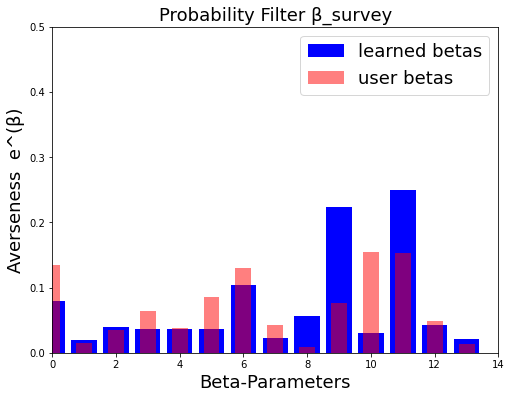

In [23]:
''' get learned betas '''
betaLearnedList = GetLearnedBetas(b_vec, yAxis=0.5, saveFig=False, title=filterName)

In [24]:
CompareChoiceOutcomes(explMatrixScaled, betaLearnedList)
LiklihoodRatioIndex(explMatrixScaled, b_vec, choice_nk)

[0, 2, 0, 0, 3, 2, 2, 0, 1, 1, 0, 0, 3, 3, 0, 0, 1, 2, 0, 2, 3, 0, 3, 0, 1, 3, 1, 1, 2, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 1, 3, 2, 2, 1, 0, 0, 3, 0, 2, 0, 3, 3, 0, 1, 0, 0, 2, 3, 0, 2, 1, 1, 0, 0, 2, 3, 2, 0, 3, 1, 3, 3, 3, 1, 2, 0, 1, 3, 2, 1, 1, 3, 0, 2, 3, 3, 1, 2, 0, 1, 3, 2, 1, 2, 2, 0, 2, 2, 2, 2]
[0, 2, 0, 0, 3, 0, 2, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 2, 0, 2, 3, 0, 3, 0, 1, 3, 1, 2, 1, 3, 1, 1, 3, 2, 2, 1, 3, 3, 3, 1, 3, 2, 2, 3, 0, 0, 3, 0, 2, 0, 3, 3, 0, 1, 0, 0, 3, 3, 0, 1, 2, 1, 0, 0, 2, 2, 2, 0, 2, 1, 3, 3, 3, 1, 2, 0, 1, 3, 2, 1, 1, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2]
1st best matches to true user betas: 83 out of 100
%-of-right: 83.0

[0, 2, 0, 0, 3, 2, 2, 0, 1, 1, 0, 0, 3, 3, 0, 0, 1, 2, 0, 2, 3, 0, 3, 0, 1, 3, 1, 1, 2, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 1, 3, 2, 2, 1, 0, 0, 3, 0, 2, 0, 3, 3, 0, 1, 0, 0, 2, 3, 0, 2, 1, 1, 0, 0, 2, 3, 2, 0, 3, 1, 3, 3, 3, 1, 2, 0, 1, 3, 2, 1, 1, 3, 0, 2, 3, 3, 1, 2, 0, 1, 3, 2, 1, 2, 2, 0, 2, 2, 2, 2]
[1, 1, 3, 2, 0, 2, 0, 3, 0, 

#### Save Learned Betas

In [25]:
# file path for preprocessed dataframes
try:
    from src.a_star import prep_dataframes  #note: MMWPF path must be added to enviornmental variables PYTHONPATH (see setup.py)
    prep_path = prep_dataframes.path()
except:
    prep_path = os.path.join("./", "prep_dataframes")
    if not os.path.exists(prep_path):
        print('%s path does not exist!' % prep_path)

# save precalculated lst_id to file
beta_file_name = os.path.join(prep_path, "b_survey_probability_filter_betas")
try: 
    geeky_file = open(beta_file_name, 'wb') 
    pickle.dump(betaLearnedList, geeky_file) 
    geeky_file.close() 
except: 
    print("Something went wrong")